# Lab 7: Function compression and the SVD

This lecture will explore using the SVD to compress 2D functions sampled at an
evenly spaced grid. This is very much the same as image compression,
but we will see that samples of smooth functions can be approximated by very small rank matrices.
This gives some intuition on why pictures tend to be low rank: most pictures have large portions that are "smooth".

The following code samples a function on a grid in the square `[-1,1]^2`
and plots the corresponding pixels:

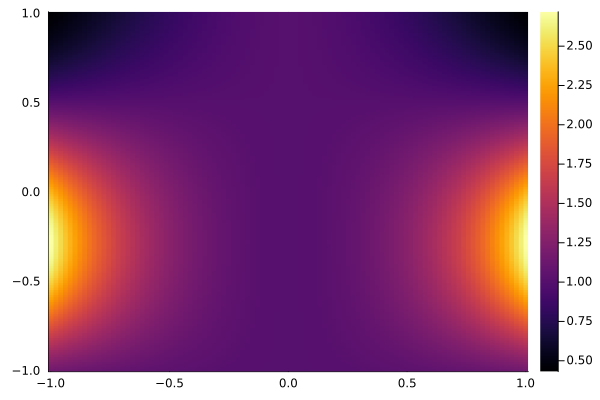

In [1]:
using Plots, LinearAlgebra, Test

f = (x,y) -> exp(-x^2*sin(2y-1))

m,n = 150,100
x = range(-1, 1; length=n)
y = range(-1, 1; length=m)

F = f.(x', y) # equivalent to [f(x[j],y[k]) for k=1:m, j=1:n]

heatmap(x, y, F)

In [2]:
x = range(-1, 1; length=10)
println(x)
println(x')

-1.0:0.2222222222222222:1.0
[-1.0 -0.7777777777777778 -0.5555555555555556 -0.3333333333333333 -0.1111111111111111 0.1111111111111111 0.3333333333333333 0.5555555555555556 0.7777777777777778 1.0]


**Problem 1** Complete the following function `fsample(f, m, n)` which takes in a function
and returns its samples on a grid.

In [3]:
function fsample(f::Function, m::Int, n::Int)
    # TODO: return `f` sampled at an evenly spaced grid on the square [-1, 1]^2
    # with n points in the x direction and
    # n points in the y direction, returning an m × n matrix

    x = range(-1, 1; length=n)
    y = range(-1, 1; length=m)
    
    f.(x', y)
end

@test fsample(f, m, n) == F

Test Passed

------
## Singular values of 2D function samples

We will  see experimentally that the singular values
tell us something about the structure functions.  Recall from lectures
the singular value decomposition is a matrix factorization of a
matrix $A ∈ ℝ^{m × n}$ of the form

$$
A = U Σ V^⊤
$$

where $U ∈ ℝ^{m × r}$, $Σ ∈ ℝ^{r × r}$ and $V ∈ ℝ^{n × r}$, where $U$ and $V$
have orthogonal columns and $Σ$ is diagonal.   The singular values are the diagonal entries of $Σ$.

Note that `svdvals(A)` calculates the singular values of a matrix `A`, without calculating
the `U` and `V` components.

**Problem 2.1** Use `plot(...; yscale=:log10)` and `svdvals` to plot the singular values of
$f(x,y) = \exp(-x^2 \sin(2y-1))$ sampled at a $100 × 150$ evenly spaced grid on $[-1,1]^2$.
At what value does it appear to level off?

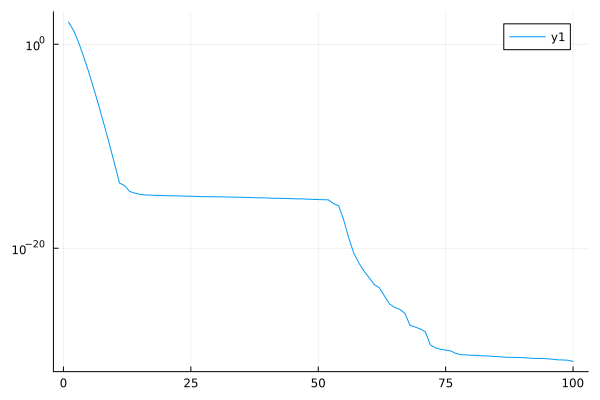

In [4]:
plot(svdvals(fsample(f, 150, 100)); yscale=:log10) # plots position in list against value
                                                   # svdvals returns values in descending order

Levels off at 10 on x-axis.

**Problem 2.2** Repeat Problem 2.1, but plotting the first 20 singular values divided by `n`
for `n = m = 50`, `n = m = 100`, and `n = m = 200` on the same figure.  What do you notice?
Hint: recall `plot!` adds a plot to an existing plot.

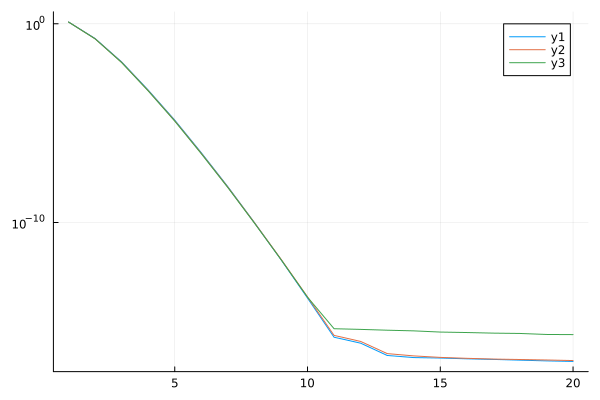

In [5]:
plot(svdvals(fsample(f, 50, 50))[1:20]/ 50; yscale=:log10)

plot!(svdvals(fsample(f, 100, 100))[1:20]/ 100; yscale=:log10)

plot!(svdvals(fsample(f, 200, 200))[1:20]/ 200; yscale=:log10)

**Problem 2.3** Plot the first 50 singular values for `n = m = 200` of
 $\cos(ωxy)$ and $\cos(ωx) \cos(ωy)$ for `ω` equal to 1,10 and 50, on the same figure.
How do the singular values change as the functions become more oscillatory in both examples?

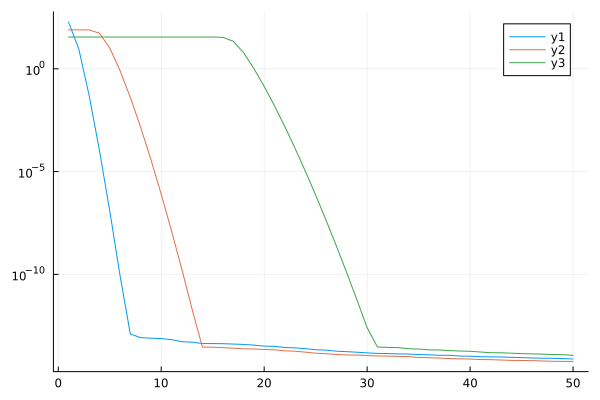

In [6]:
plot(svdvals(fsample((x,y) -> cos(x * y), 200, 200))[1:50]; yscale=:log10)
plot!(svdvals(fsample((x,y) -> cos(10 * x * y), 200, 200))[1:50]; yscale=:log10)
plot!(svdvals(fsample((x,y) -> cos(50 * x * y), 200, 200))[1:50]; yscale=:log10)

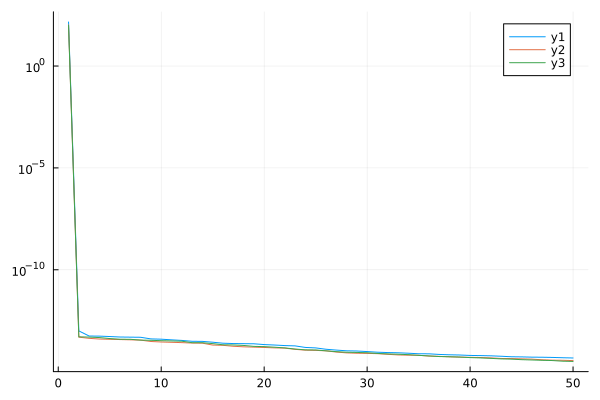

In [7]:
plot(svdvals(fsample((x,y) -> cos(x) * cos(y), 200, 200))[1:50]; yscale=:log10)
plot!(svdvals(fsample((x,y) -> cos(10 * x) * cos(10 * y), 200, 200))[1:50]; yscale=:log10)
plot!(svdvals(fsample((x,y) -> cos(50 * x) * cos(50 * y), 200, 200))[1:50]; yscale=:log10)

**Problem 2.4** Plot the singular values of ${\rm sign}(x-y)$ for `n=m=100`
and `n=m=200`.  What do you notice?

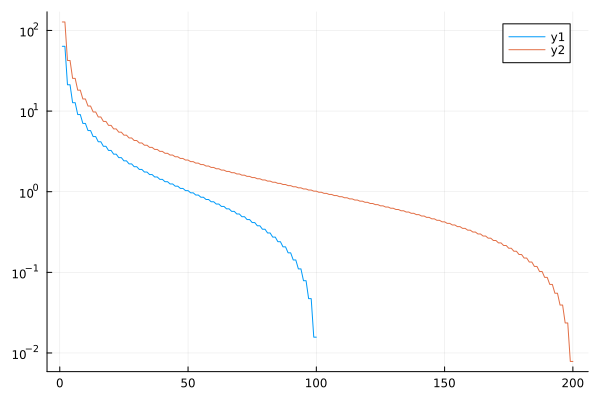

In [8]:
plot(svdvals(fsample((x,y) -> sign(x - y), 100, 100)); yscale=:log10)
plot!(svdvals(fsample((x,y) -> sign(x - y), 200, 200)); yscale=:log10)

-----
## Matrix compression

We now turn to using the SVD to compress matrices.

**Problem 3.1** Write a function `svdcompress(A::Matrix, k::Integer)` that returns the best rank-`k` approximation to `A`,
using the in-built `svd` command.

In [9]:
function svdcompress(A::Matrix, k::Integer)
    U, sig, V = svd(A)
    sig_k = Diagonal(sig[1:k])
    U_k = U[:, 1:k]
    V_k = V[:, 1:k]
    A_k = U_k * sig_k * V_k'
    A_k
end

svdcompress (generic function with 1 method)

**Problem 3.2** Compare a `heatmap` plot of `fsample((x,y) -> exp(-x^2*sin(2y-1)), 100, 100)` to its best rank-5 approximation.
What do you observe?

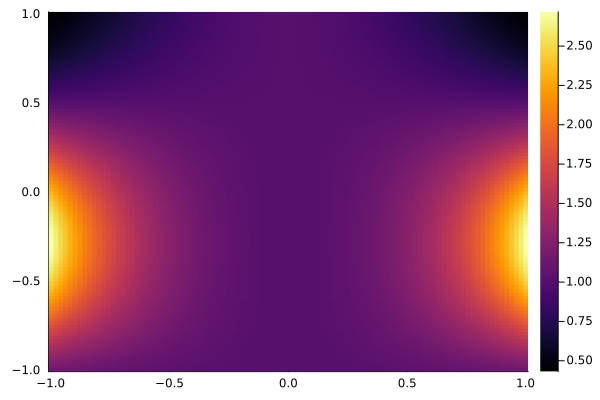

In [10]:
x = range(-1, 1; length=100)
y = range(-1, 1; length=100)

heatmap(x, y, fsample((x,y) -> exp(-x^2*sin(2y-1)), 100, 100))

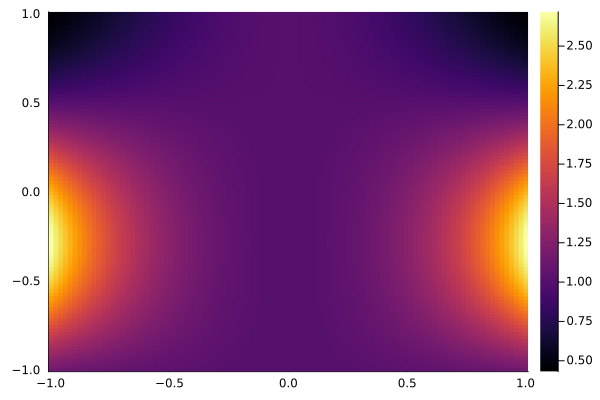

In [11]:
heatmap(x, y, svdcompress(fsample((x,y) -> exp(-x^2*sin(2y-1)), 100, 100), 5))

They are basically the same.

**Problem 3.3** Write a function `svdcompress_rank(A::Matrix, ε::Real)` that returns the smallest integer `k` so that `norm(A - svdcompress(A, k)) ≤ ε`,
which we call the "numerical rank".   (Hint: use the singular values instead of guess-and-check.)

In [12]:
function svdcompress_rank(A::Matrix, ε::Real)
    # TODO: determine and return rank-k approximation
    k = 1
    while norm(A - svdcompress(A, k)) > ε
        k += 1
    end
    k + 1
end
F = fsample((x,y) -> exp(-x^2*sin(2y-1)), 100, 100)
@test svdcompress_rank(F, 1E-10) == 10

Test Passed

**Problem 3.4** Use `svdcompress_rank` to roughly estimate how the numerical rank of the Hilbert matrix
$$
H_n := \begin{bmatrix} 1 & 1/2 & 1/3 & ⋯ & 1/n \\
                      1/2 & 1/3 & 1/4 & ⋯ & 1/(n+1) \\
                       1/3 & 1/4 & 1/5 & ⋯ & 1/(n+2) \\
                       ⋮ & ⋮ & ⋮ & ⋱ & ⋮ \\
                       1/n & 1/(n+1) & 1/(n+2) & ⋯ & 1/(2n-1)
                       \end{bmatrix}
$$
grows as a function
of $n$ up to $n = 200$, for $ε = 10^{-10}$.
Hint: scaling just the x axis in a plot via `plot(...; xscale=:log10)` will reveal logarithmic
growth.

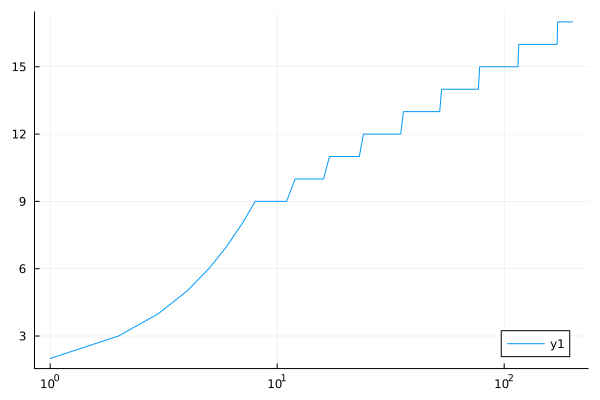

In [13]:
hilbertmatrix(n) = [1/(k + j - 1) for j = 1:n, k = 1:n]

k = [svdcompress_rank(hilbertmatrix(n), 10 ^ -10) for n = 1:200]
    
plot(k; xscale=:log10)

------

We will see later in the module (time-permitting) that divided differences lead naturally to
methods for solving differential equations. For example, if we take the equation
$$
\begin{align*}
u(0) &= 1, \\
u'(t) &= a u(t)
\end{align*}
$$
and consider the solution on a grid of evenly spaced points $t_0,t_1,…,t_n = 0, h, 2h, …, (n-1)h, 1$,
where $h = 1/n$,
we have
$$
0 = u'(t_k) - a u(t_k) ≈ {u(t_{k+1}) - u(t_k) \over h} - a u(t_k).
$$
Writing $u_k ≈ u(t_k)$ we get a _discrete_ version of the ODE:
$$
\begin{align*}
u_0 &= 1, \\
u_{k+1}/h - (1/h+a)u_k &= 0\qquad\hbox{ for $k = 0,…,n-1$}
\end{align*}
$$
Solving this linear system gives an approximation to the solution to the ODE (in this case $u(t) = \exp(a t)$).

**Problem 5.1** Complete the following function that returns a (lower) `Bidiagonal` matrix of dimension
(n+1) × (n+1) representing the above linear system, i.e., acting on the vector `[u_0,u_1,…,u_n]`.
Hint: recall the `fill` command and that `[1; vc]` will concatenate the number `1` with a vector `vc`.

In [14]:
function forwardeuler(a, n)
    # TODO: return a Bidiagonal matrix representing the above linerar system
    o = n * ones(n)
    a = a * ones(n)
    d = [1; o]
    ld = o + a
    Bidiagonal(d, -ld, :L)
end

n = 100_000
x = range(0, 1; length=n+1)
@test forwardeuler(1, n) isa Bidiagonal
@test norm(forwardeuler(1, n) \ [1; zeros(n)] - exp.(x)) ≤ 0.005

Test Passed

In [15]:
x = range(0, 1; length=n+1)
exp.(x)
[1; zeros(n)]

100001-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [16]:
?Bidiagonal

search: Bidiagonal



```
Bidiagonal(dv::V, ev::V, uplo::Symbol) where V <: AbstractVector
```

Constructs an upper (`uplo=:U`) or lower (`uplo=:L`) bidiagonal matrix using the given diagonal (`dv`) and off-diagonal (`ev`) vectors. The result is of type `Bidiagonal` and provides efficient specialized linear solvers, but may be converted into a regular matrix with [`convert(Array, _)`](@ref) (or `Array(_)` for short). The length of `ev` must be one less than the length of `dv`.

# Examples

```jldoctest
julia> dv = [1, 2, 3, 4]
4-element Vector{Int64}:
 1
 2
 3
 4

julia> ev = [7, 8, 9]
3-element Vector{Int64}:
 7
 8
 9

julia> Bu = Bidiagonal(dv, ev, :U) # ev is on the first superdiagonal
4×4 Bidiagonal{Int64, Vector{Int64}}:
 1  7  ⋅  ⋅
 ⋅  2  8  ⋅
 ⋅  ⋅  3  9
 ⋅  ⋅  ⋅  4

julia> Bl = Bidiagonal(dv, ev, :L) # ev is on the first subdiagonal
4×4 Bidiagonal{Int64, Vector{Int64}}:
 1  ⋅  ⋅  ⋅
 7  2  ⋅  ⋅
 ⋅  8  3  ⋅
 ⋅  ⋅  9  4
```

---

```
Bidiagonal(A, uplo::Symbol)
```

Construct a `Bidiagonal` matrix from the main diagonal of `A` and its first super- (if `uplo=:U`) or sub-diagonal (if `uplo=:L`).

# Examples

```jldoctest
julia> A = [1 1 1 1; 2 2 2 2; 3 3 3 3; 4 4 4 4]
4×4 Matrix{Int64}:
 1  1  1  1
 2  2  2  2
 3  3  3  3
 4  4  4  4

julia> Bidiagonal(A, :U) # contains the main diagonal and first superdiagonal of A
4×4 Bidiagonal{Int64, Vector{Int64}}:
 1  1  ⋅  ⋅
 ⋅  2  2  ⋅
 ⋅  ⋅  3  3
 ⋅  ⋅  ⋅  4

julia> Bidiagonal(A, :L) # contains the main diagonal and first subdiagonal of A
4×4 Bidiagonal{Int64, Vector{Int64}}:
 1  ⋅  ⋅  ⋅
 2  2  ⋅  ⋅
 ⋅  3  3  ⋅
 ⋅  ⋅  4  4
```


**Problem 5.2** For $a = 1$, plot the condition number of `forwardeuler(1,n)` for increasing $n$, up to
$n = 200$. Can you estimate at what rate the condition number is growing? I.e., if the growth can be bounded by
$C n^α$ give a conjecture on what $α$ is sufficient.  What does this tell us about a bound on the growth in round-off error in the approximation?
Hint: if you scale both the x axis and y axis logarithmically via `plot(...; xscale=:log10, yscale=:log10)`
then the slope indicates which algebraic rate a function is growing. You may plot $n^α$ for varying $α$ to find a slope that
is bigger than the observed data.

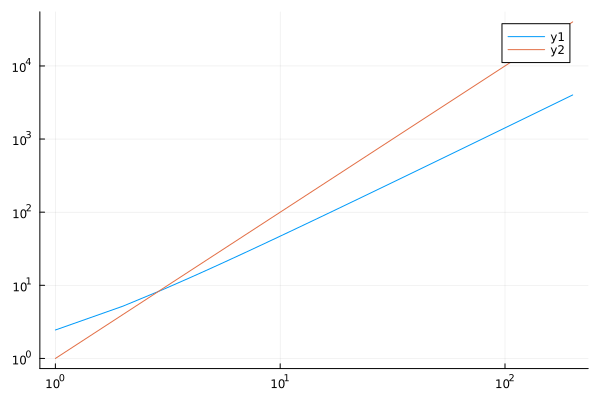

In [33]:
vals = [norm(forwardeuler(1, n)) for n = 1:200]

plot(vals; xscale=:log10, yscale=:log10)
plot!([x ^ 2 for x = 1:200])

$\alpha = 2$ 

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*